# Regression model

This notebook explores and models the data collected from recordings of the natural acoustic environment over the urban-rural gradient near Innsbruck, Austria. The models are implemented as Bayesian models with the PyMC3 probabilistic programming library.

References:<br />
https://github.com/fonnesbeck/multilevel_modeling<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

#### Import statements

In [113]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import numpy

In [3]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import seaborn
import mpld3
from mpld3 import plugins

In [114]:
from pymc3 import glm, Model, NUTS, sample, \
                  forestplot, traceplot, plot_posterior, summary, \
                  Normal, Uniform, Deterministic, StudentT

#### Variable definitions

In [5]:
data_filepath = ""

## Load data

In [6]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

In [7]:
data[['site', 'site_name', 'building_pavement_200m', 'forest_200m']].head()

,site,site_name,building_pavement_200m,forest_200m
1,15,Hofgarten,34.716504,40.635720
2,26,Bienenstraße,60.392767,20.139944
3,5,Gumppstraße,81.331017,12.070743
4,21,Templstraße,77.336232,17.342644
5,18,Egger-Lienz-Straße,74.866665,12.899635


sort data by site and then by visit

In [8]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

In [9]:
data_sorted[['site', 'site_name', 'biophony', 
             'forest_200m', 'temperature', 'days']].head(n=10)

,site,site_name,biophony,forest_200m,temperature,days
0,1,Lans,83.522323,70.934164,9.9,28.0
1,1,Lans,81.196749,70.934164,10.4,42.0
2,1,Lans,84.231717,70.934164,18.0,76.0
3,1,Lans,89.147379,70.934164,23.9,85.0
4,1,Lans,86.715442,70.934164,7.9,91.0
5,2,Hofwald,76.131350,97.068706,5.9,22.0
6,2,Hofwald,75.306785,97.068706,4.3,36.0
7,2,Hofwald,86.630363,97.068706,2.1,48.0
8,2,Hofwald,89.550034,97.068706,22.2,69.0
9,2,Hofwald,86.640584,97.068706,13.9,90.0


## Plot data

Here is a pairwise plot of a subset of the data. The 'days' variable represents the number of days each recording was taken from the start of field collection (Janurary 27, 2016). The 'forest_200m' represents the percentage of landcover within a 200-meter radius of each recording location, and the 'temperature' variable represents the temperature in degrees Celcius, averaged from the measurements taken at the University of Innsbruck weather station 30 minutes before and after each recording. The 'biophony' and 'anthrophony' variables are shown in decibels (relative and log scale), and they are on different scales as a result of the source separation algorithm (will be fixed soon).

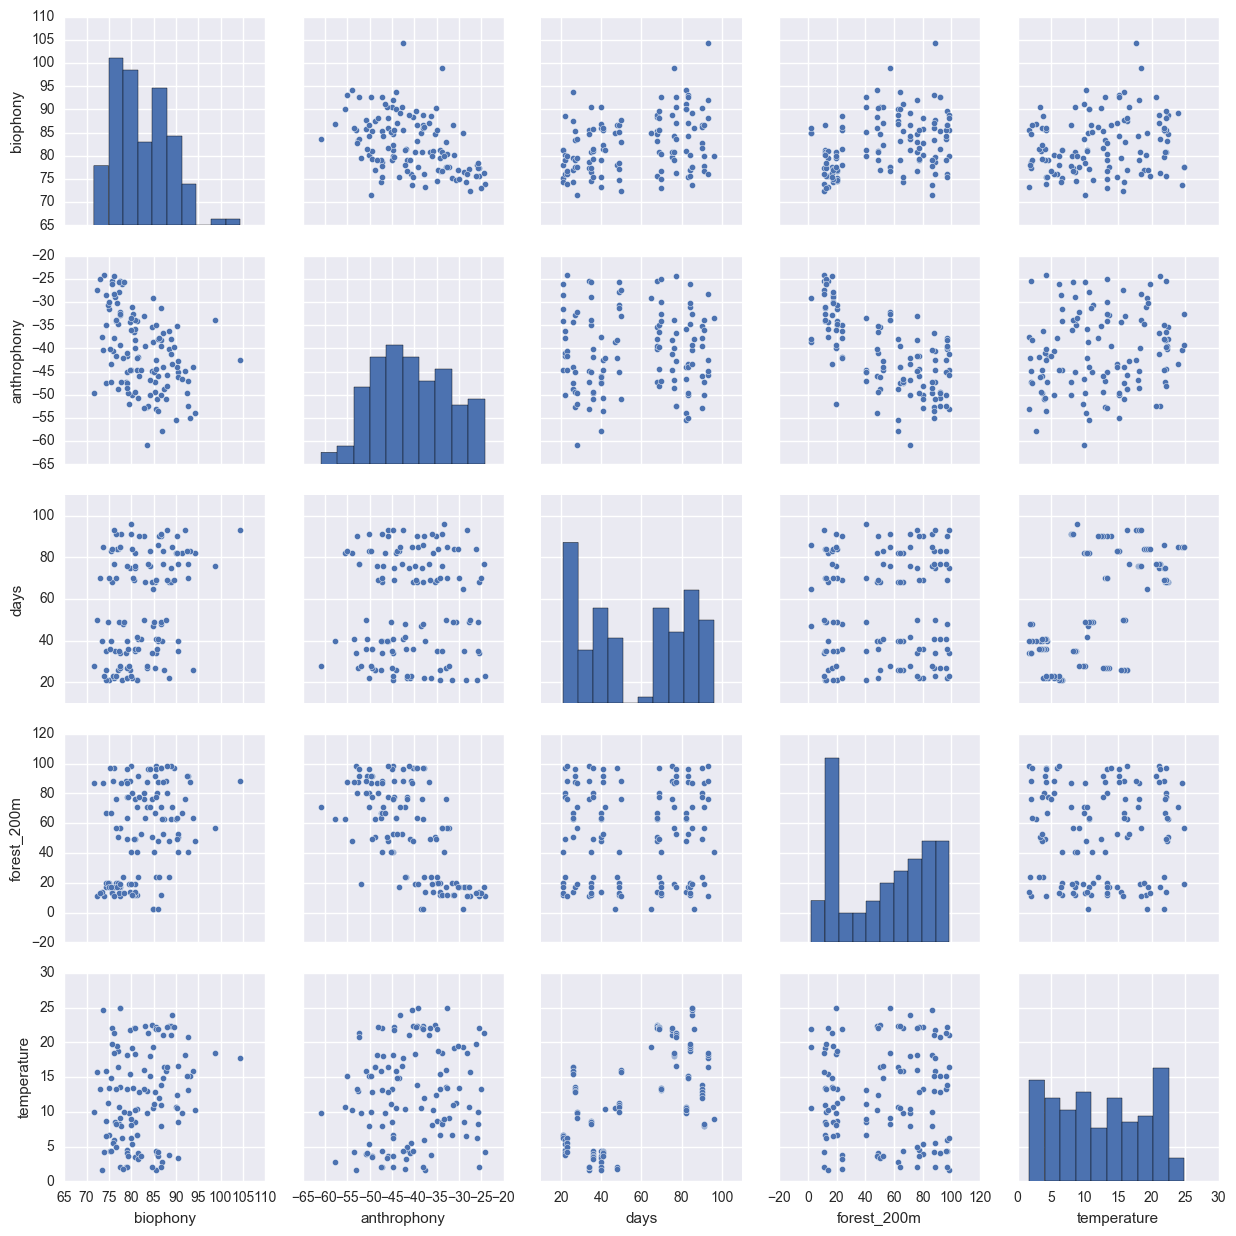

In [10]:
pairplot = seaborn.pairplot(data[['biophony', 'anthrophony', 
                                  'days', 'forest_200m', 'temperature']])

There is definitely a relationship between biophony and landcover, although a more robust analysis might be able to explain the relationship better than the simple regression shown below.

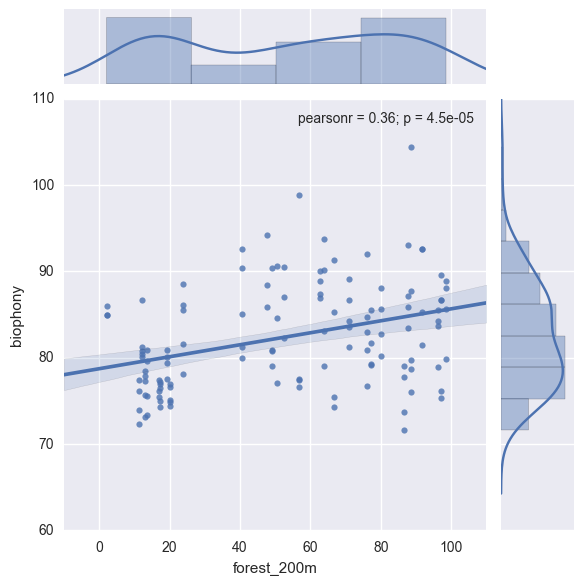

In [11]:
biophony_jointplot = seaborn.jointplot('forest_200m', 'biophony', data=data, kind='reg', 
                                       xlim=(-10, 110), ylim=(60, 110))

Landcover seems to have a greater effect on anthrophony.

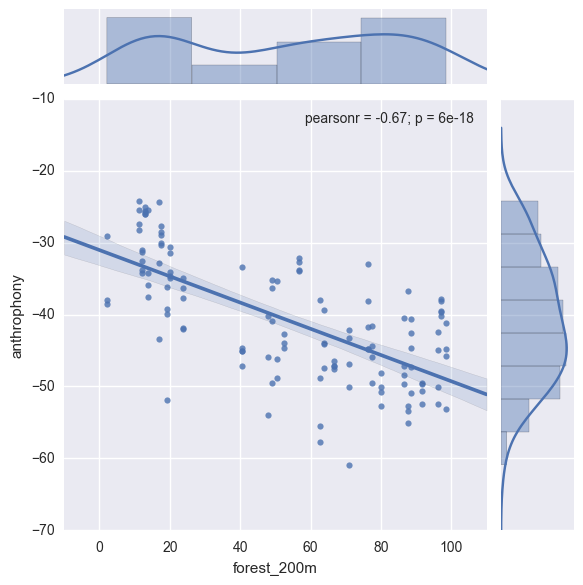

In [12]:
anthrophony_jointplot = seaborn.jointplot('forest_200m', 'anthrophony', data=data, kind='reg', 
                                          xlim=(-10, 110), ylim=(-70, -10))

As the boxplots show, repeated measurements of anthrophony and biophony varry little at some sites and greatly at others.

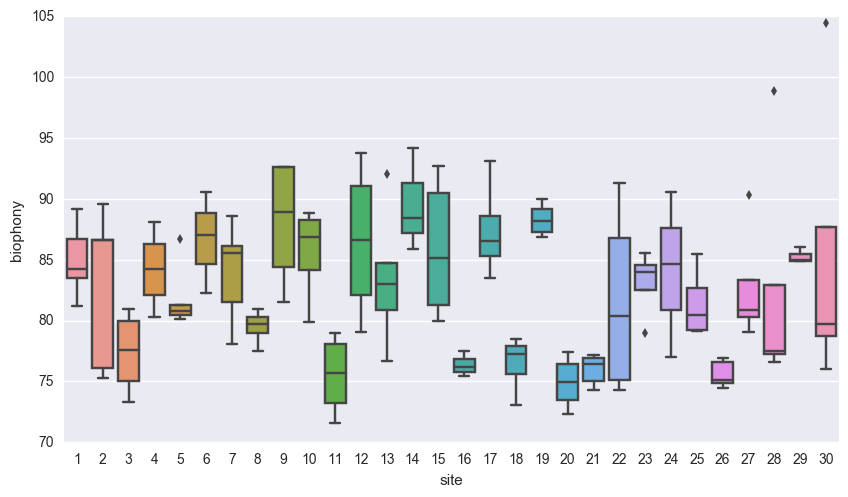

In [115]:
biophony_boxplot = seaborn.boxplot('site', 'biophony', data=data)
biophony_boxplot.figure.set_figwidth(10)

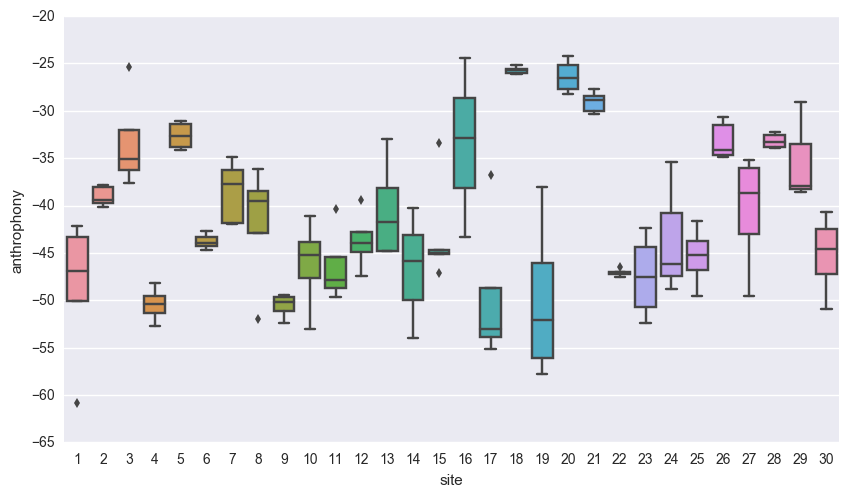

In [116]:
anthrophony_boxplot = seaborn.boxplot('site', 'anthrophony', data=data)
anthrophony_boxplot.figure.set_figwidth(10)

## Complete pooling

We can look at a standard regression analysis to compare it with more robust multilevel models. We start with a "complete pooling" analysis, considering only the 'days' variable (effectively time of year) as a predictor for biophony. 

$$y_i = \alpha + \beta x_i$$

We start with the model defined above, where yi is the biophony at recording i, alpha is the intercept, beta is the slope, and xi is the number of days from the start of field collection for recroding i.

We can define the model in PyMC3 and run it with 1000 samples.

In [ ]:
with Model() as pooled_model:
    glm.glm("biophony ~ days", data)
    pooled_trace = sample(1000, NUTS(), random_seed=1)

In [18]:
intercept0 = pooled_trace['Intercept'][500:].mean()
slope0 = pooled_trace['days'][500:].mean()

In [19]:
intercept0

78.099774888535109

In [20]:
slope0

0.075710025822399191

Here is a plot of the data and the fitted regression line.

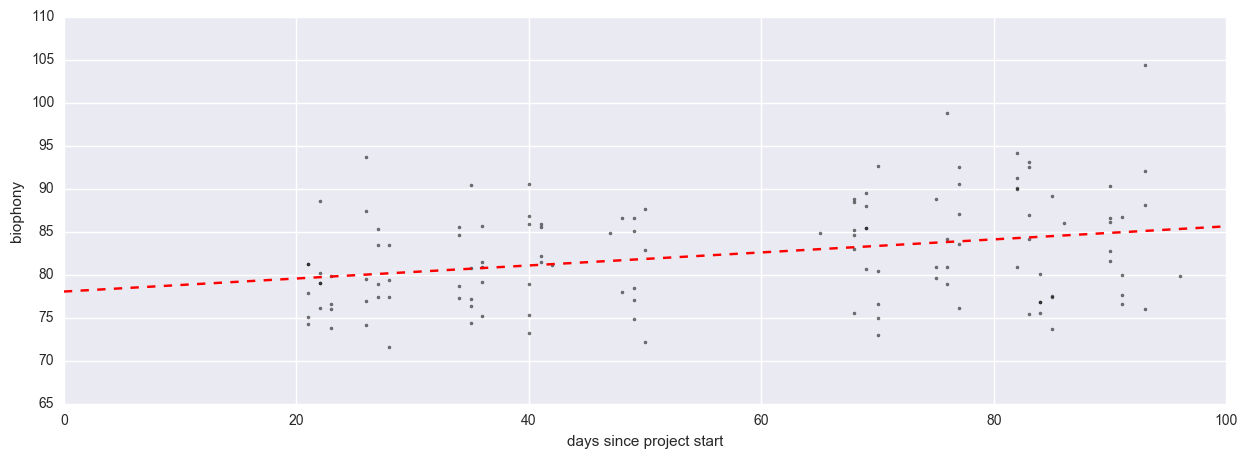

In [77]:
fig, ax = pyplot.subplots(figsize=(15, 5))
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)
x_days = numpy.linspace(0, 100)
p1 = ax.plot(x_days, intercept0 + slope0*x_days, 'r--')
l1 = ax.set_xlabel("days since project start")
l2 = ax.set_ylabel("biophony")
f1 = ax.set_xlim([0, 100])

## No pooling

The complete pooling model above does not allow the regression parameters to vary by site, which is likely unrealistic. For example, it seems probable that the change of biophony over time could vary between location. We can see what happens if we fit a separate regression to each site (different intercept (alpha) and slope (beta) for each site j).

$$y_{ij} = \alpha_j + \beta_j x_i$$

In [22]:
sample_sites = (2, 9, 11, 15, 17, 18, 26, 30)

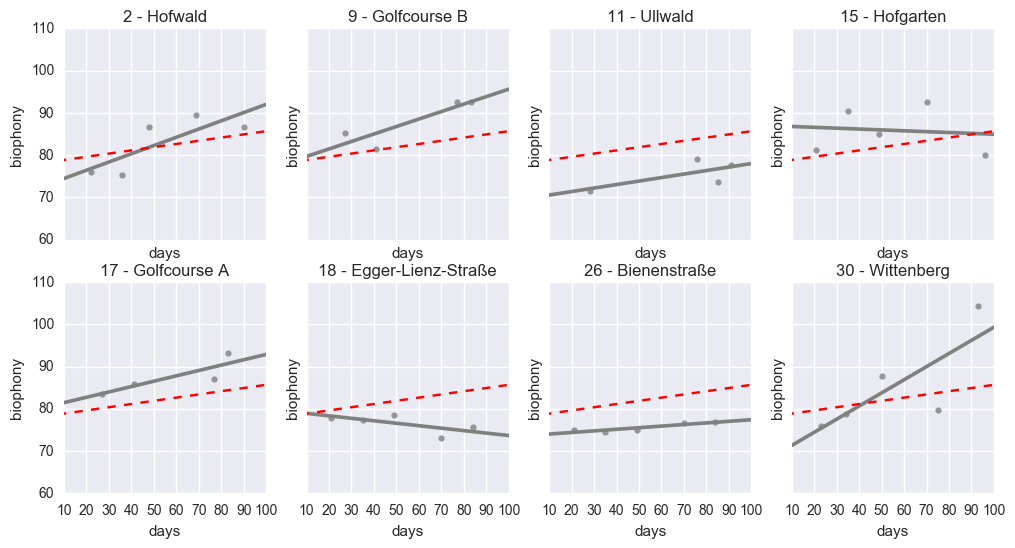

In [23]:
fig, ax = pyplot.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    # plot data and regression line
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    seaborn.regplot(x, y, ax=ax[i], ci=None, color='grey')
    
    # plot complete pooling regression line and set format
    x_days = numpy.linspace(0, 100)
    ax[i].plot(x_days, (slope0 * x_days) + intercept0, 'r--')
    ax[i].set_title("{0} - {1}".format(site, data_sorted.site_name[data_sorted.site == site].unique()[0]))
    ax[i].set_ylim([60, 110])

## Partial pooling (empty model)

We can see from the no pooling example that biophony does seem to change differently at each location. However, as shown below, a multilevel model allows us to apply a single model to the data set while allowing regression parameters to vary between sites. For sites with a lesser amount of measurements, the regression parameters are pulled towards the parameters of the entire data set (towards complete pooling), but for sites with a large amount of measurements, the regression parameters are not pulled towards the entire data set (towards no pooling).

The model shown below contains no predictors (refered to as the empty model), and thus shows only how the mean biophony varies between locations.

$$y_{ij} = \beta_{j} + r_{ij}$$
$$\beta_{j} = \gamma + u_{j}$$

In the equation above, y represents the biophony for recording i and location j, beta represents the mean biophony of each location j, gamma represents the grand mean of biophony (mean of the location means), u represents the difference between the mean biophony at location j and the grand mean biophony, and r represents the difference between the biophony of recording i at location j and the mean biophony at location j. The model can also be thought of as defining a separate intercept for each site with no slope.

We can define this model in PyMC3 as shown below.<br />
NOTE: While the model equations are shown in frequentist form, PyMC3 implements the models in a Bayesian context.

In [24]:
sites = numpy.copy(data_sorted.site.values) - 1

In [ ]:
with Model() as partial_pooling:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony)

In [ ]:
with partial_pooling:
    step = NUTS()
    partial_pooling_samples = sample(2000, step, random_seed=1)

We can plot both the unpooled means and the partially-pooled means.

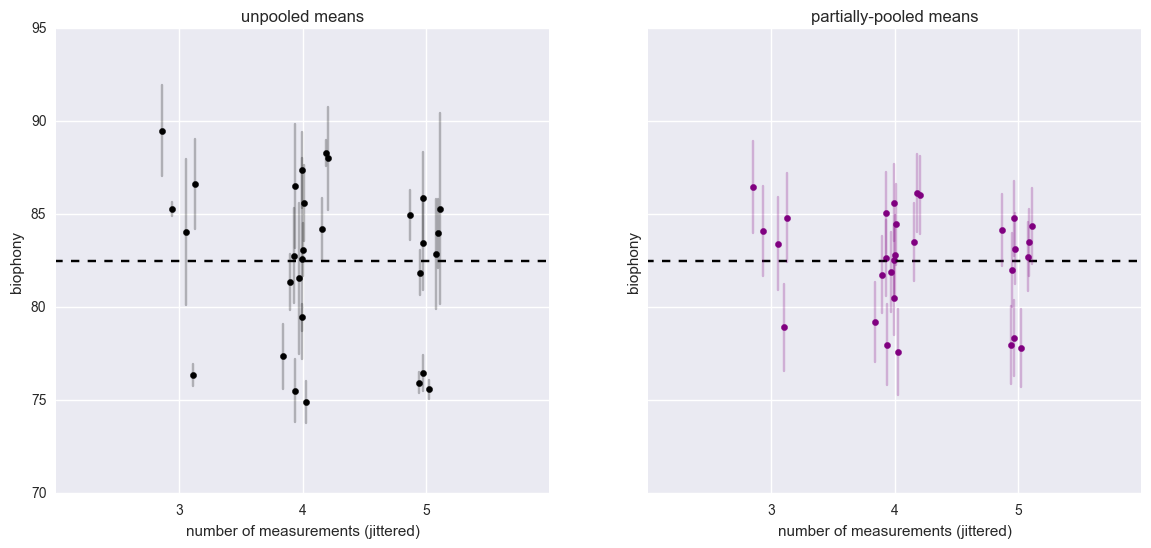

In [27]:
sample_trace = partial_pooling_samples['a'][-1000:]

fig, ax = pyplot.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, sites = sample_trace.shape
jitter = numpy.random.normal(scale=0.1, size=sites)

n_site = data.groupby('site')['biophony'].count()
unpooled_means = data.groupby('site')['biophony'].mean()
unpooled_sd = data.groupby('site')['biophony'].std()
unpooled = pandas.DataFrame({'n':n_site, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd / numpy.sqrt(unpooled.n)

# plot unpooled means
ax[0].scatter(unpooled.n + jitter, unpooled.m, marker='o', color='black')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    ax[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 
               linestyle='-', color='black', alpha=0.25)
t1 = ax[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
ax[0].set_xticks([3, 4, 5])
t2 = ax[0].set_title('unpooled means')
t3 = ax[0].set_xlabel('number of measurements (jittered)')
t4 = ax[0].set_ylabel('biophony')

# plot partially-pooled means
samples, sites = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
ax[1].scatter(n_site.values + jitter, means, marker='o', color='purple')
ax[1].set_xlim(2, 6)
ax[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_site.values, means, sd):
    ax[1].plot([n+j]*2, [m-s, m+s], linestyle='-', color='purple', alpha=0.25)
t1 = ax[1].set_title('partially-pooled means')
t2 = ax[1].set_xlabel('number of measurements (jittered)')
t3 = ax[1].set_ylabel('biophony')

Note that there is less pooling for sites with a higher number of measurements.

## Varying intercepts

Going forward with the multilevel model and partial pooling, we can begin to add predictors. This model adds the 'days' variable as a predictor, but does not allow the effect (slope) to vary between locations. However, in this model the intercepts are allowed to vary, but without a predictor.

$$
\begin{align}
\text{level 1} \\
y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij} \\
\text{level 2} \\
\beta_{0j} = \gamma_{00} + u_{0j} \\
\beta_{1j} = \gamma_{10} \\
\end{align}
$$

In [28]:
sites = numpy.copy(data_sorted.site.values) - 1

In [ ]:
with Model() as varying_intercept:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b * data_sorted.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony)

In [ ]:
with varying_intercept:
    step = NUTS()
    varying_intercept_samples = sample(2000, step, random_seed=1)

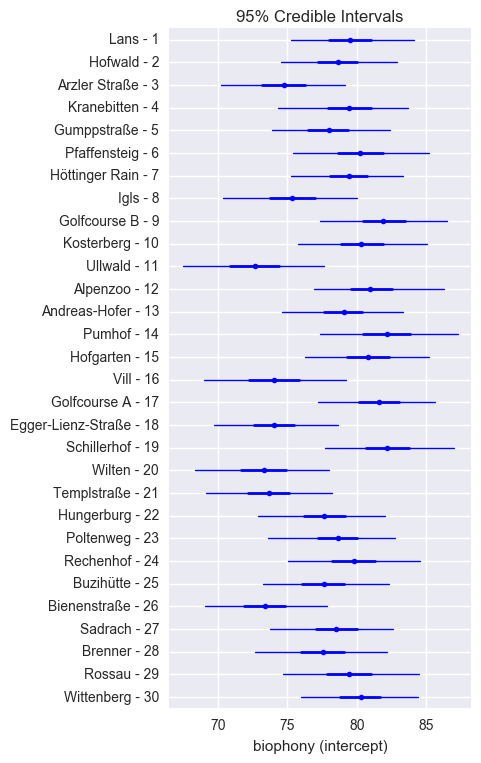

In [31]:
site_labels = ["{1} - {0}".format(s, 
                                  data_sorted.site_name[data_sorted.site == s].unique()[0])\
               for s in range(1, 31)]
pyplot.figure(figsize=(5, 8))
p1 = forestplot(varying_intercept_samples, varnames=['a'], 
                ylabels=site_labels,
                xtitle="biophony (intercept)")

We can also plot the sample traces and distributions for other variables defined in the model. Here 'sigma_a' represents the variance between the grand biophony mean and each location biophony mean, and 'b' represents the slope for all locations.

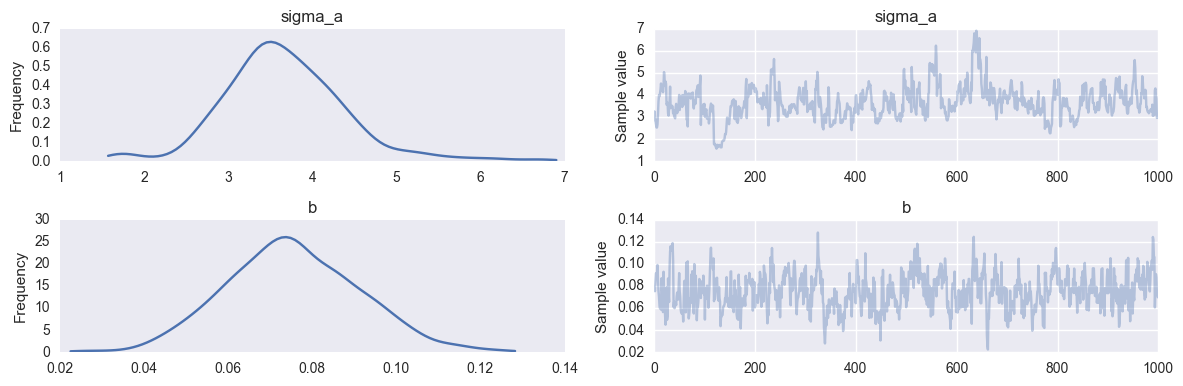

In [32]:
p1 = traceplot(varying_intercept_samples[-1000:], varnames=['sigma_a', 'b'])

We can also print a summary with confidence for each model variable. The summary below shows that the estimated slope ('b') parameter is 0.075, meaning that for each increase in 'days' the biophony value increases by 0.075

In [33]:
summary(varying_intercept_samples[-1000:], varnames=['b'])


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.075            0.016            0.001            [0.044, 0.105]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.046          0.065          0.075          0.086          0.107



Now we can plot a regression line for each location.

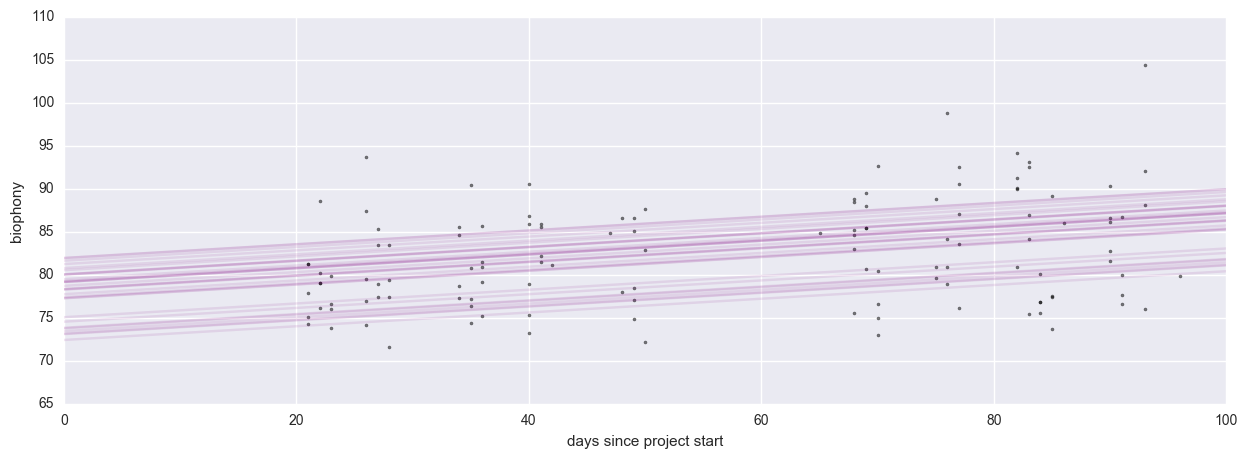

In [48]:
fig, ax = pyplot.subplots(figsize=(15, 5))
x_days = numpy.arange(0, 110, 10)
bp = varying_intercept_samples['a'].mean(axis=0)
mp = varying_intercept_samples['b'].mean()
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)
for bi in bp:
    ax.plot(x_days, mp * x_days + bi, color='purple', marker=None, alpha=0.1)
l1 = ax.set_xlabel("days since project start")
l2 = ax.set_ylabel("biophony")
f1 = ax.set_xlim([0, 100])

Here are separate plots for each location, showing three different regressions.

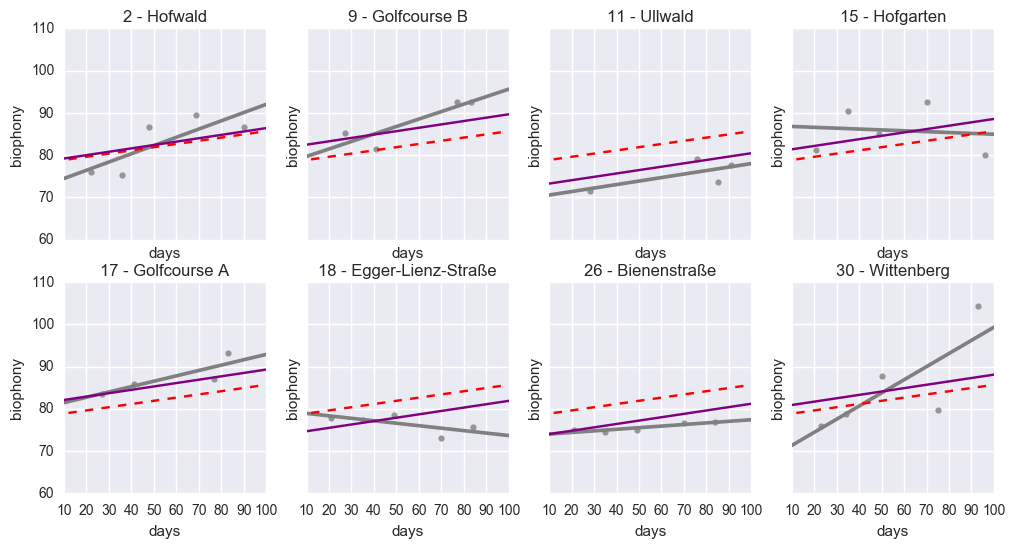

In [35]:
fig, ax = pyplot.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    
    # Plot county data and unpooled regression
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    seaborn.regplot(x, y, ax=ax[i], ci=None, color='grey')
    
    # plot pooled and partially-pooled regressions
    x_days = numpy.linspace(-10, 110)
    # Pooled estimate
    ax[i].plot(x_days, slope0 * x_days + intercept0, 'r--')
    # Partial pooling esimate
    ax[i].plot(x_days, mp * x_days + bp[site - 1], color='purple', marker=None, linestyle='-')
    ax[i].set_title("{0} - {1}".format(site, data_sorted.site_name[data_sorted.site == site].unique()[0]))
    ax[i].set_ylim([60, 110])

# Varying slope

We can also see what happens if we fix a common intercept, but allow the slope to vary between locations.

$$
\begin{align}
\text{level 1} \\
y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij} \\
\text{level 2} \\
\beta_{0j} = \gamma_{00} \\
\beta_{1j} = \gamma_{10} + u_{1j} \\
\end{align}
$$

In [36]:
sites = numpy.copy(data_sorted.site.values) - 1

In [ ]:
with Model() as varying_slope:
    
    # Priors
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Model intercept
    a = Normal('a', mu=0., tau=0.0001)
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a + b[sites] * data_sorted.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony)

In [ ]:
with varying_slope:
    step = NUTS()
    varying_slope_samples = sample(2000, step, random_seed=1)

Here is a plot of the estimated slope for each location.

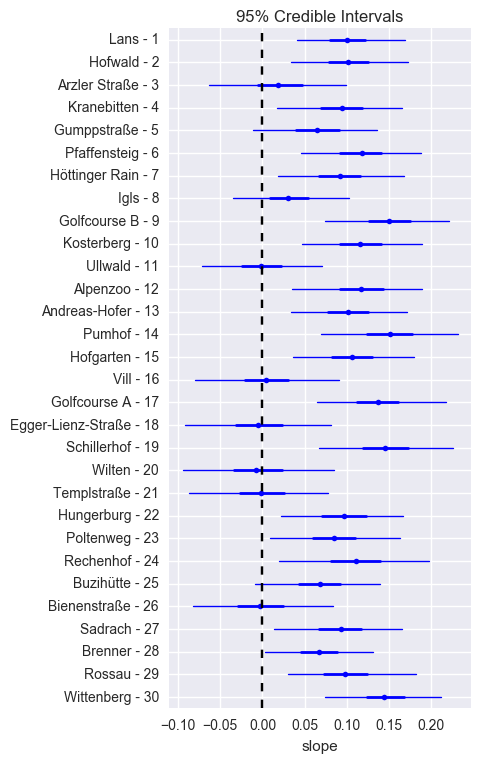

In [39]:
site_labels = ["{1} - {0}".format(s, 
                                  data_sorted.site_name[data_sorted.site == s].unique()[0])\
               for s in range(1, 31)]
pyplot.figure(figsize=(5, 8))
p1 = forestplot(varying_slope_samples, varnames=['b'], 
                ylabels=site_labels,
                xtitle="slope")

This result is interesting, as locations with an estimated slope near 0 (e.g., Wilten and Templstraße) are generally located in areas with mostly urban land cover, and other locations with higher estimated slopes (e.g., Pumhof and Wittenberg) are generally located in areas with a large amount of forest land cover.

Here is a plot of the regression lines for all the locations.

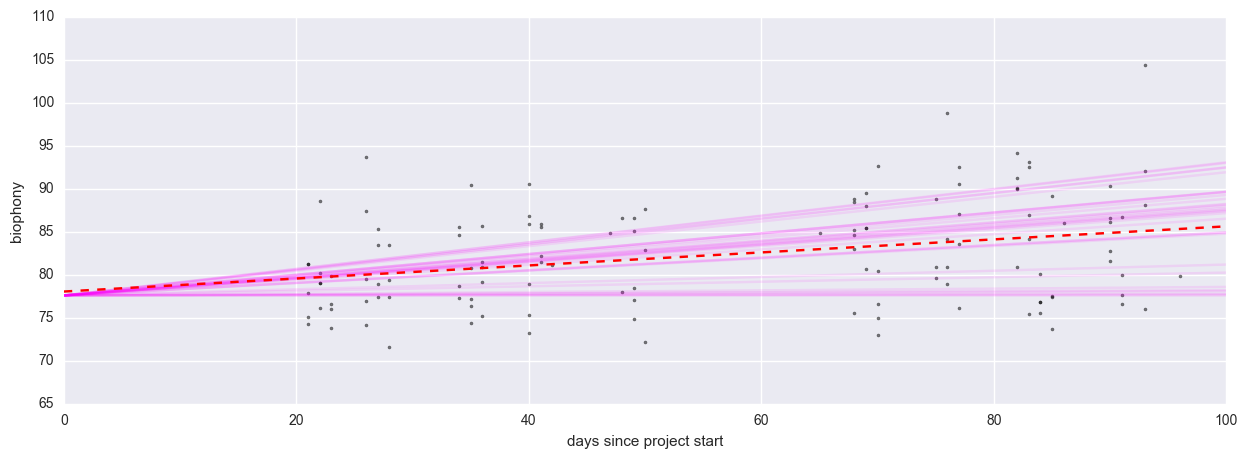

In [46]:
fig, ax = pyplot.subplots(figsize=(15, 5))

# all data
p1 = ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes
x_days = numpy.arange(0, 110, 100)
b = varying_slope_samples['a'].mean()
m = varying_slope_samples['b'].mean(axis=0)
for mi in m:
    pi = ax.plot(x_days, mi * x_days + b, marker=None, color='magenta', alpha=0.1)
    
# pooled
p2 = ax.plot(x_days, intercept0 + slope0 * x_days, marker=None, color='red', linestyle='--')

# formatting
l1 = ax.set_xlabel("days since project start")
l2 = ax.set_ylabel("biophony")
f1 = ax.set_xlim([0, 100])

## Varying slope and intercept

Now we can try varying both slope and intercept.

$$
\begin{align}
\text{level 1} \\
y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij} \\
\text{level 2} \\
\beta_{0j} = \gamma_{00} + u_{0j} \\
\beta_{1j} = \gamma_{10} + u_{1j} \\
\end{align}
$$

In [50]:
sites = numpy.copy(data_sorted.site.values) - 1

In [ ]:
with Model() as varying_intercept_slope:
    
    # Priors    
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b[sites] * data_sorted.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony)

In [ ]:
with varying_intercept_slope:
    step = NUTS()
    varying_intercept_slope_samples = sample(2000, step, random_seed=1)

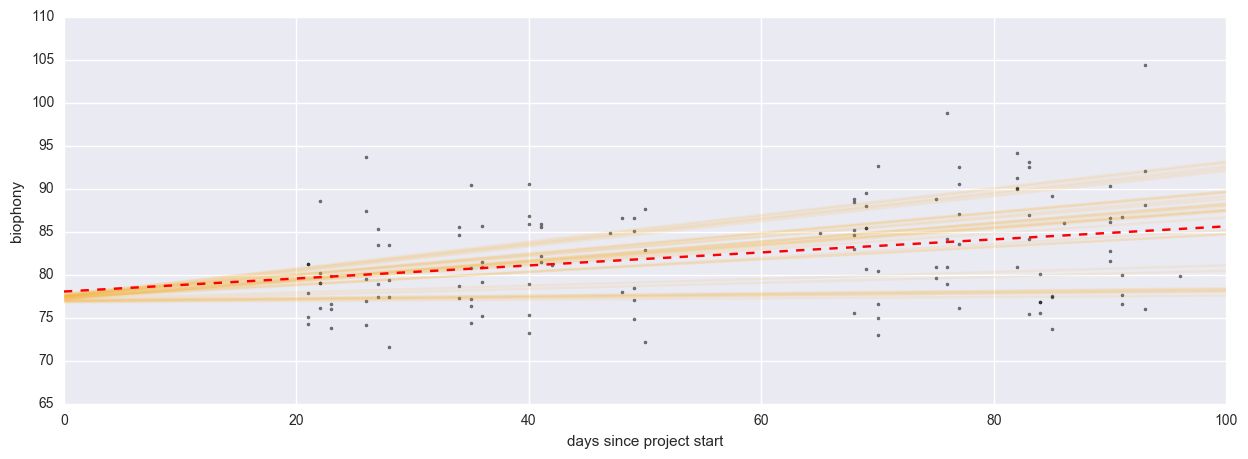

In [85]:
fig, ax = pyplot.subplots(figsize=(15, 5))

# all data
p1 = ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes and intercepts
x_days = numpy.arange(0, 110, 100)
b = varying_intercept_slope_samples['a'].mean(axis=0)
m = varying_intercept_slope_samples['b'].mean(axis=0)
for bi,mi in zip(b,m):
    pi = ax.plot(x_days, mi * x_days + bi, marker=None, color='orange', alpha=0.1)

# pooled
p2 = ax.plot(x_days, intercept0 + slope0 * x_days, marker=None, color='red', linestyle='--')

# formatting
l1 = ax.set_xlabel("days since project start")
l2 = ax.set_ylabel("biophony")
f1 = ax.set_xlim([0, 100])

Here are plots for individual locations again, comparing this model (orange) compares with the unpooled model (gray).

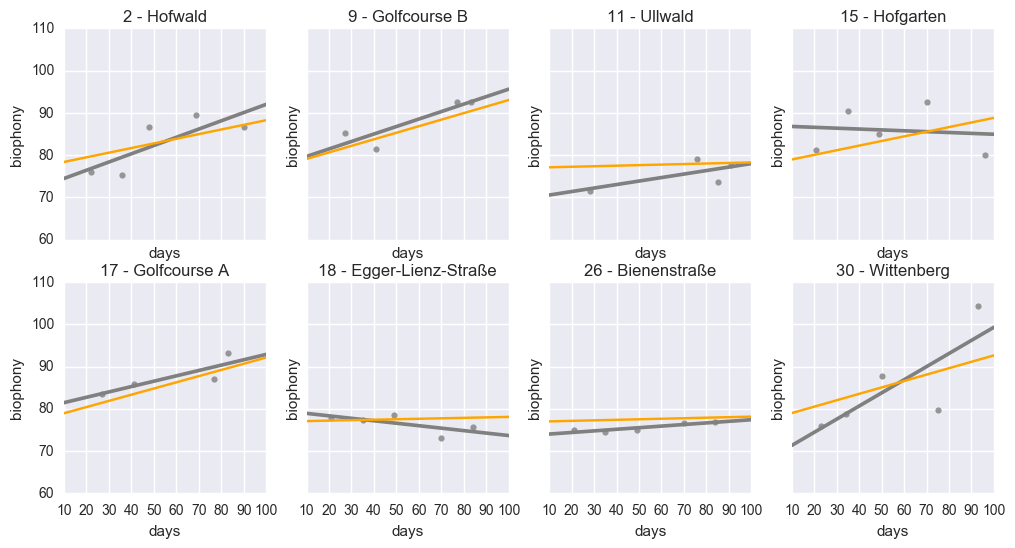

In [90]:
fig, ax = pyplot.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    
    # Plot county data and unpooled regression
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    seaborn.regplot(x, y, ax=ax[i], ci=None, color='grey')
    
    # Plot pooled and partially-pooled regressions
    x_days = numpy.linspace(-10, 110)
    # Pooled estimate
    #ax[i].plot(x_days, slope0 * x_days + intercept0, 'r--', alpha=0.5)
    # Partial pooling esimate
    #ax[i].plot(x_days, mp * x_days + bp[site - 1], color='purple', marker=None, linestyle='-', alpha=0.5)
    # Varying slopes and intercepts
    ax[i].plot(x_days, m[site - 1] * x_days + b[site - 1], color='orange', marker=None, linestyle='-')
    ax[i].set_title("{0} - {1}".format(site, data_sorted.site_name[data_sorted.site == site].unique()[0]))
    ax[i].set_ylim([60, 110])

## Model 3 — adding group-level predictors

Now we can try to see if we can assign a predictor to the level 2 (group or location level) parameters. Land cover is likely to be a significant predictor of the amount of biophony (intercept) and how it changes over time (slope).

There are many predictor variables in the data set, but we can define an aggregate predictor from what is likely to be the predictors with the largest effect. We define the 'forest_net_200m' variable that is the percentage of forest land cover minus the combined percentage of buildings and paved surfaces land cover within a 200-meter radius of each recording location. We can later check the fit of the model with many different predictor variables.

In [67]:
data_sorted['forest_net_200m'] = data_sorted.forest_200m - data_sorted.building_pavement_200m

In [68]:
data_sorted[['site', 'forest_200m', 'forest_net_200m']].groupby('site').mean().head()

,forest_200m,forest_net_200m
site,,
1,70.934164,64.039087
2,97.068706,94.241497
3,13.668314,-29.951781
4,79.950193,79.453945
5,12.070743,-69.260273


Here is the model, this time defined in Bayesian form.

$$
\begin{align}
\text{level 1} \\
y_i \sim \mathcal{N}(\alpha_{j[i]} + \beta_{j[i]} x_{i}, \sigma^2_y), \\
\text{for $i = 1,...,n$} \\
\text{level 2} \\
\alpha_j \sim \mathcal{N}(\gamma_{00} + \gamma_{01} u_{j}, \sigma^2_{\alpha}), \\
\beta_{j} \sim \mathcal{N}(\gamma_{10} + \gamma_{11} u_{j}, \sigma^2_{\beta}), \\
\text{for $j = 1,...,J$}
\end{align}
$$
where $x_i$ is the measurement-level days indicator and $u_j$ is the location-level land cover indicator

We transform and center some of the variables to make it easier to interpret the model results.

In [71]:
data_sorted['biophony_centered'] = data_sorted.biophony - data_sorted.biophony.mean()
data_sorted['weeks_centered'] = (data_sorted.days - data_sorted.days.mean()) / 7
data_sorted['forest_net_200m_centered'] = data_sorted.forest_net_200m - data_sorted.forest_net_200m.mean()

In [72]:
sites = numpy.copy(data_sorted.site.values) - 1

In [ ]:
with Model() as model_3:
    
    # intercept
    g_00 = Normal('g_00', mu=0, tau=0.001)
    g_01 = Normal('g_01', mu=0, tau=0.001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    mu_a = g_00 + (g_01 * data_sorted.forest_net_200m_centered.unique())
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    
    # slope
    g_10 = Normal('g_10', mu=0, tau=0.001)
    g_11 = Normal('g_11', mu=0, tau=0.001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    mu_b = g_10 + (g_11 * data_sorted.forest_net_200m_centered.unique())
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # model error (data-level)
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # expected values
    y_hat = a[sites] + (b[sites] * data_sorted.weeks_centered)
    
    # likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony_centered)

In [ ]:
with model_3:
    step = NUTS()
    model_3_samples = sample(10000, step, random_seed=1)

We can compute the estimated intercept and slope for each location based on the mean of the last 5000 samples from the model trace.

In [76]:
trace = model_3_samples[-5000:]
a_means = trace['a'].mean(axis=0)
b_means = trace['b'].mean(axis=0)

Now we can compare how well the estimated level 2 parameters predict the estimated level 1 parameters.

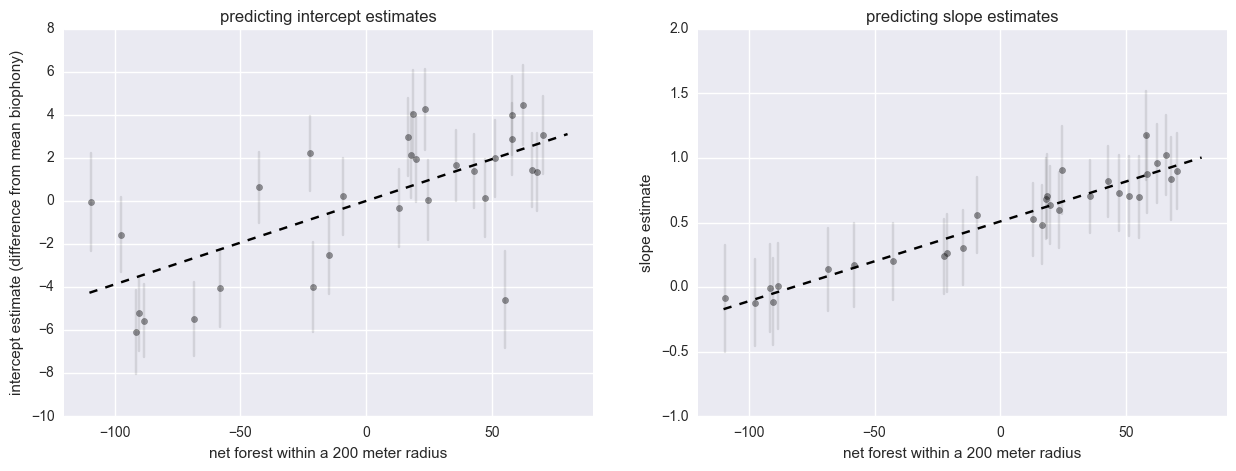

In [96]:
fig, ax = pyplot.subplots(1, 2, sharex=True, figsize=(15, 5))

# plot estimated level 2 parameter (intercept)
intercept_points = ax[0].scatter(data_sorted.forest_net_200m_centered.unique(), a_means, color='black', alpha=0.4)
g00 = trace['g_00'].mean()
g01 = trace['g_01'].mean()
x_forest = numpy.linspace(-110, 80)
p1 = ax[0].plot(x_forest, g00 + (g01 * x_forest), color='black', linestyle='--')
pl = ax[0].set_xlim(-120, 90)

# plot estimated level 1 parameters
a_se = trace['a'].std(axis=0)
for xi, m, se in zip(data_sorted.forest_net_200m_centered.unique(), a_means, a_se):
    pi = ax[0].plot([xi, xi], [m-se, m+se], color='black', alpha=0.1)
t1 = ax[0].set_xlabel('net forest within a 200 meter radius')
t2 = ax[0].set_ylabel('intercept estimate (difference from mean biophony)')
t0 = ax[0].set_title('predicting intercept estimates')

# for interactive plot via mpld3
#intercept_point_labels = ["{0}: {1:0.2f}".format(n, s) for n, s in zip(data_sorted.site_name.unique(), a_means)]
#tooltip = plugins.PointLabelTooltip(intercept_points, intercept_point_labels)
#plugins.connect(fig, tooltip)
#mpld3.display(fig)

# plot estimated level 2 parameter (slope)
slope_points = ax[1].scatter(data_sorted.forest_net_200m_centered.unique(), b_means, color='black', alpha=0.4)
g10 = trace['g_10'].mean()
g11 = trace['g_11'].mean()
x_forest = numpy.linspace(-110, 80)
p2 = ax[1].plot(x_forest, g10 + (g11 * x_forest), color='black', linestyle='--')
pl = ax[1].set_xlim(-120, 90)

# plot estimated level 1 parameters
b_se = trace['b'].std(axis=0)
for xi, m, se in zip(data_sorted.forest_net_200m_centered.unique(), b_means, b_se):
    pi = ax[1].plot([xi, xi], [m-se, m+se], color='black', alpha=0.1)
t3 = ax[1].set_xlabel('net forest within a 200 meter radius')
t4 = ax[1].set_ylabel('slope estimate')
t5 = ax[1].set_title('predicting slope estimates')

# for interactive plot via mpld3
#slope_point_labels = ["{0}: {1:0.2f}".format(n, s) for n, s in zip(data_sorted.site_name.unique(), b_means)]
#tooltip = plugins.PointLabelTooltip(slope_points, slope_point_labels)
#plugins.connect(fig, tooltip)
#mpld3.display(fig)

Above, we can see that the land cover variable (forest_net_200m) can decentely predict how much biophony changes at each location over time (right plot). The intercept values do not fit quite as well, although there still seems to be a clear relationship (left plot). The two major outliers may be caused by errors in the source separation algorithm. We can compute an R squared value for each level 2 parameter and for all of level 1 (see below).

First, here are individual plots for all the locations.

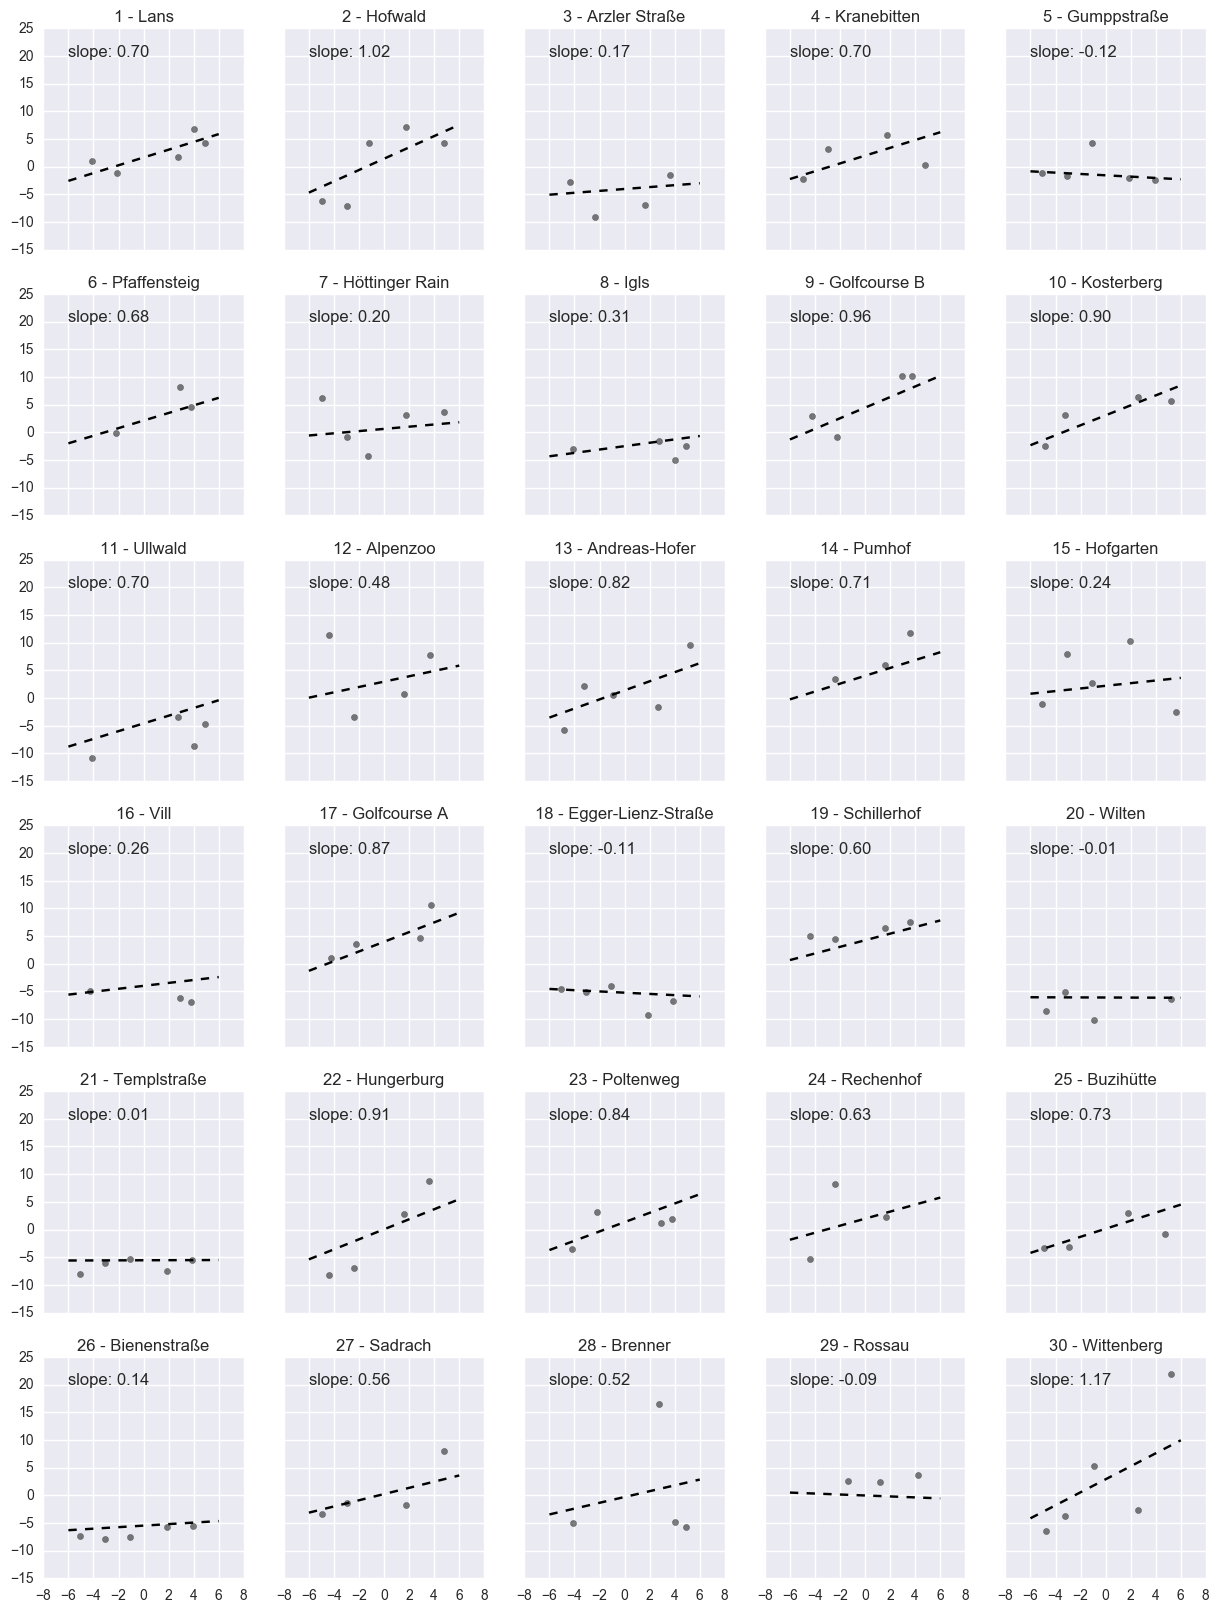

In [77]:
fig, ax = pyplot.subplots(6, 5, figsize=(15, 20), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(data_sorted.site.unique()):
    
    # observed data (points)
    y = data_sorted.biophony_centered[data_sorted.site==site]
    x = data_sorted.weeks_centered[data_sorted.site==site]
    ax[i].scatter(x + numpy.random.randn(len(x))*0.01, y, color='black', alpha=0.5)
    
    # model estimate (line)
    x_days = numpy.linspace(-6, 6, 2)
    ax[i].plot(x_days, a_means[i] + (b_means[i] * x_days), color='black', linestyle='--')
    ax[i].set_title("{0} - {1}".format(site, data_sorted.site_name[data_sorted.site == site].unique()[0]))
    ax[i].text(-6, 20, "slope: {0:.02f}".format(b_means[i]))

## Calculate R squared

As defined in Gelman and Hill 2006, we can compute (effective) R squared values for the multilevel model.

In [98]:
# level 1
a_means_expanded = numpy.array([a_means[v-1] for v in data_sorted.site])
b_means_expanded = numpy.array([b_means[v-1] for v in data_sorted.site])
y_hat = a_means_expanded + (b_means_expanded * data_sorted.weeks_centered)
e_y = data_sorted.biophony_centered - y_hat
r2_level1 = 1 - (e_y.var() / data_sorted['biophony_centered'].var())

# level 2
a_hat = g00 + (g01 * data_sorted.groupby('site')['forest_net_200m'].mean())
b_hat = g10 + (g11 * data_sorted.groupby('site')['forest_net_200m'].mean())
e_a = a_means - a_hat
e_b = b_means - b_hat
# R squared for intercept estimates
r2_level2a = 1 - (e_a.var() / a_means.var())
# R squared for slope estimates
r2_level2b = 1 - (e_b.var() / b_means.var())

In [108]:
print("R squared values:\n\
      level 1\n\
      ----------\n\
      overall:    {0:0.2f}\n\
      \n\
      level 2\n\
      ----------\n\
      intercepts: {1:0.2f}\n\
      slopes:     {2:0.2f}".format(r2_level1, r2_level2a, r2_level2b))

R squared values:
      level 1
      ----------
      overall:    0.60
      
      level 2
      ----------
      intercepts: 0.44
      slopes:     0.91


## Analysis of variance (ANOVA)

In [109]:
trace.varnames

['g_00',
 'g_01',
 'sigma_a_interval_',
 'a',
 'g_10',
 'g_11',
 'sigma_b_interval_',
 'b',
 'sigma_y_interval_',
 'sigma_a',
 'sigma_b',
 'sigma_y']

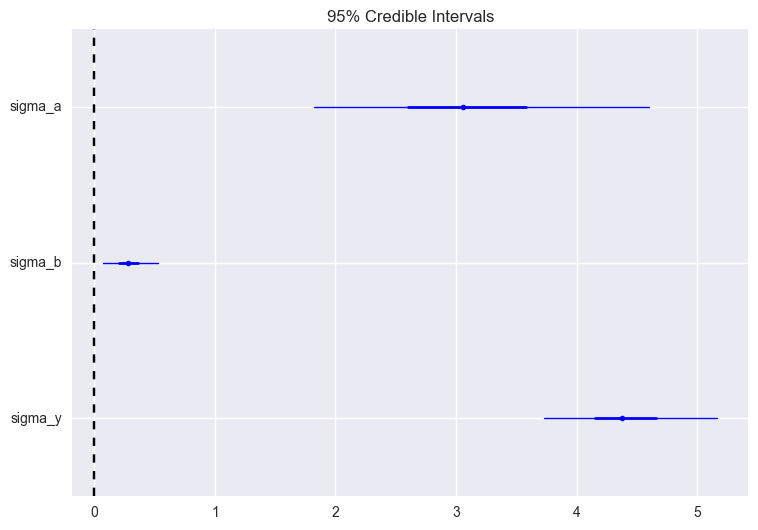

In [111]:
p1 = forestplot(trace, varnames=['sigma_a', 'sigma_b', 'sigma_y'])